# *lsforce* example script: Triangle parameterization
---

This example script produces the force-time function for a very large landslide occurring near Attabad Lake in Pakistan on 4 January 2010 (Ekström & Stark, 2013) but using only a subset of the stations used in that study for faster processing. Here, we use the "triangle" model vector parameterization method, which constructs the force-time function from a series of overlapping triangles of a specified half-width.

**References**

Ekström, G., & Stark, C. P. (2013). Simple Scaling of Catastrophic Landslide Dynamics. *Science, 339(6126)*, 1416–1419. https://doi.org/10.1126/science.1232887

### Import necessary modules

In [1]:
from pathlib import Path

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client

from lsforce import LSData, LSForce

# Ignore benign Matplotlib backend warning due to fig.show()
import warnings
warnings.filterwarnings(action='ignore', message='Matplotlib is currently using module')

### Define some constants, set up folder structure

In [2]:
PERIOD_RANGE = (50, 150)  # [s] Bandpass filter corners

LS_LAT, LS_LON = (36.31, 74.82)  # Where the point force will be applied
ORIGIN_TIME = UTCDateTime(2010, 1, 4, 8, 36)  # From Ekström supp table

STARTTIME = ORIGIN_TIME - 100
ENDTIME = ORIGIN_TIME + 600

# Set up folder structure
main_folder = Path.cwd() / 'hunza_attabad'
if not main_folder.exists():
    main_folder.mkdir()

### Gather inversion waveforms

II.AAK.00.BHE -> II.AAK.00.BHE
{'azimuth': 95.5, 'dip': 0.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 14000 / 14000 (100%)
Max absolute difference: 337.9105433295804
Max relative difference: 122.97584570215732
 x: array([ 441.241801,  465.313082,  468.91594 , ...,  491.619444,
        486.597055,  491.943526])
 y: array([341, 364, 368, ..., 413, 412, 419], dtype=int32)

II.AAK.00.BHN -> II.AAK.00.BHN
{'azimuth': 4.8, 'dip': 0.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 14000 / 14000 (100%)
Max absolute difference: 152.56783674109556
Max relative difference: 109.88173797803893
 x: array([ 1024.671505,  1034.692417,  1030.375798, ...,   796.656331,
         754.930255,   737.421468])
 y: array([1058, 1070, 1066, ...,  835,  793,  776], dtype=int32)

II.AAK.00.BHZ -> II.AAK.00.BHZ
{'azimuth': 0.0, 'dip': -90.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 1 / 14000 (0.00714%)
Max absolute difference: 2.2737367544323206e-13
Max 

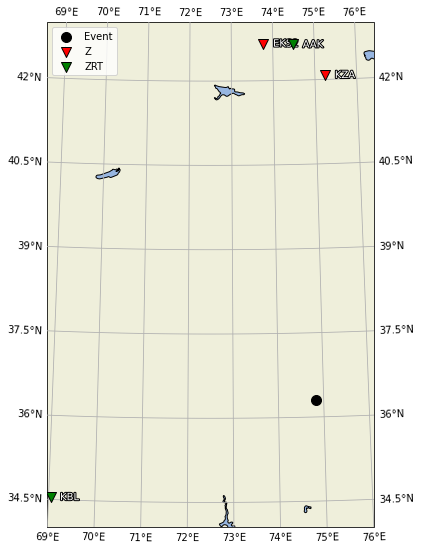

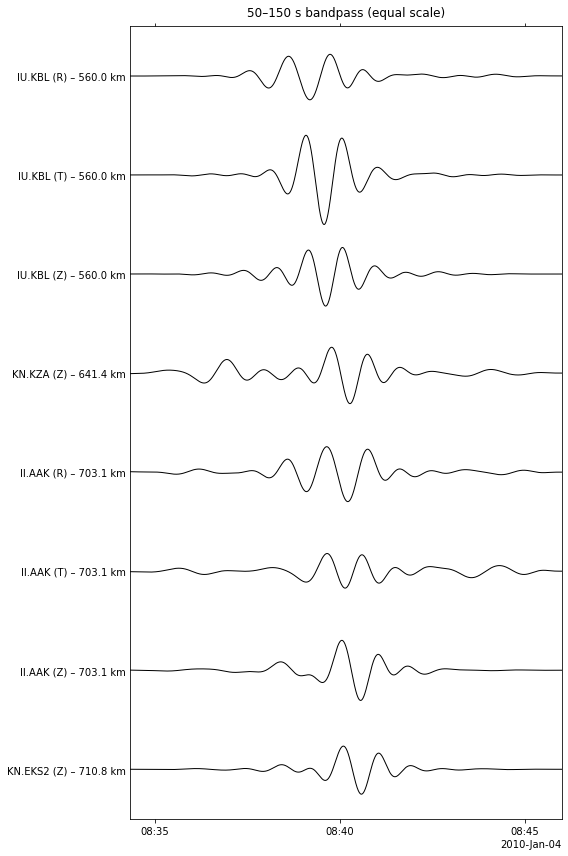

In [3]:
data_filename = main_folder / 'data.pkl'

# Download data if it doesn't exist as a file
if not data_filename.exists():

    client = Client('IRIS')
    waveform_kwargs = dict(
        channel='BHE,BHN,BHZ',
        location='00,',
        starttime=STARTTIME,
        endtime=ENDTIME,
        attach_response=True,
    )

    NETWORKS = (
        'II',
        'IU',
        'KN',
    )
    STATIONS = (
        'KBL',
        'KZA',
        'AAK',
        'EKS2',
    )
    st = client.get_waveforms(
        network=','.join(NETWORKS), station=','.join(STATIONS), **waveform_kwargs,
    )

    # Remove extra channels for station AAK
    for tr in st.select(station='AAK', location=''):
        st.remove(tr)

    # Remove horizontals
    for station in ['KZA', 'EKS2']:
        for tr in st.select(station=station, component='[EN]'):
            st.remove(tr)

    # Grab coordinates
    inv = client.get_stations(
        network=','.join(NETWORKS),
        starttime=STARTTIME,
        endtime=ENDTIME,
        level='channel',
    )

    # Assign coordinates to Traces
    for tr in st:
        coords = inv.get_coordinates(tr.id, datetime=STARTTIME)
        tr.stats.latitude = coords['latitude']
        tr.stats.longitude = coords['longitude']

    st.write(str(data_filename), format='PICKLE')

# Use file if it exists, for speed
else:
    st = read(str(data_filename), format='PICKLE')

# Create LSData object
data = LSData(st, source_lat=LS_LAT, source_lon=LS_LON)

# Detrend and taper intensively!
data.st_proc.detrend('polynomial', order=12)
data.st_proc.taper(0.3)

# Now that it's rotated, remove some radial components
for station in ['ABKT', 'KIV', 'ANTO']:
    for tr in data.st_proc.select(station=station, component='R'):
        data.st_proc.remove(tr)

# Remove additional stations
for tr in data.st_proc.select(station='ANTO', component='Z'):
    data.st_proc.remove(tr)
for tr in data.st_proc.select(station='ABKT', component='T'):
    data.st_proc.remove(tr)
for tr in data.st_proc.select(station='KIV', component='T'):
    data.st_proc.remove(tr)

# Create plots
data.plot_stations(label_stations=True, gshhs_scale='intermediate');
data.plot_data(equal_scale=True, period_range=PERIOD_RANGE);

### Setup

In [4]:
force = LSForce(
    data=data, data_sampling_rate=1, main_folder=main_folder, method='triangle'
)

force.setup(
    period_range=PERIOD_RANGE,
    zerophase=True,
    syngine_model='iasp91_2s',
    triangle_half_width=10,
)

Getting Green's functions...
Downloaded AAK (1/4)
Downloaded EKS2 (2/4)
Downloaded KBL (3/4)
Downloaded KZA (4/4)


### Invert

In [5]:
force.invert(
    zero_time=130,
    duration=60,
    impose_zero_start=True,
    add_to_zero=True,
    alpha=3.6e-18,
    zero_scaler=10,
    tikhonov_ratios=(0, 0, 1),
)

Variance reduction = 80.458346 percent


### Plot inversion

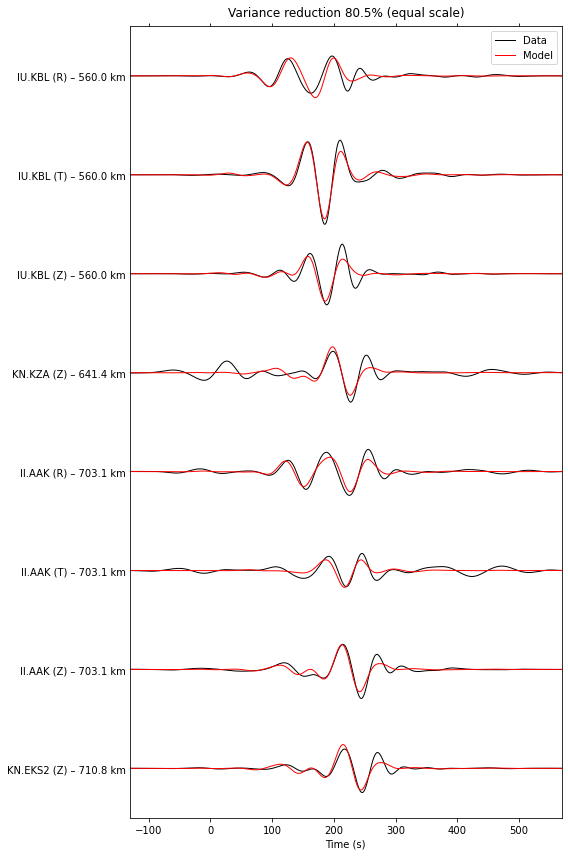

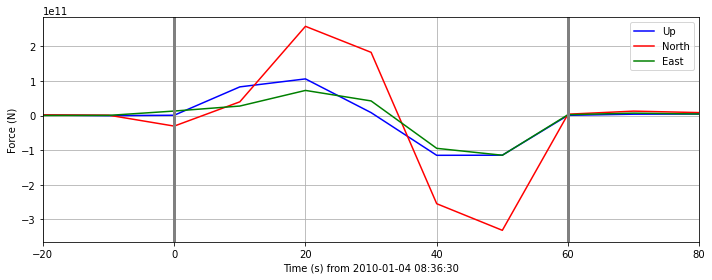

In [6]:
# Plot waveform fits
force.plot_fits();

# Plot results
force.plot_forces(xlim=[-20, 80]);